<a href="https://colab.research.google.com/github/RyanValenzuela-Porta/WarwickAI_Trading_Project/blob/main/XGBoost_Regressor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=8d804b309b96d82ce21f37482b18ab9589a457a8a9a5d43d82572f972b554d7b
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [4]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [5]:
def fetch_data(tickers, start_date, end_date):
    all_data = []
    # Columns are Adj Close  Close  High  Low Open  Volume
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        ticker_data = pd.DataFrame()

        columns = ["Adj Close","Close","High","Low","Open","Volume"]

        for col in columns:
          ticker_data[col] = df[col]
        ticker_data["Ticker"]=ticker
        all_data.append(ticker_data)

    combined_data = pd.concat(all_data)
    #print(combined_data["Ticker"])
    return combined_data

tickers = ['AAPL','MSFT']
start_date = '2010-01-01'
end_date = '2023-01-01'

# # Step 1: Fetch data
# data = fetch_data(tickers, start_date, end_date)
res = fetch_data(tickers, start_date, end_date)
# print(res["Ticker"])
res

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
2010-01-04 00:00:00+00:00,6.447410,7.643214,7.660714,7.585000,7.622500,493729600,AAPL
2010-01-05 00:00:00+00:00,6.458559,7.656429,7.699643,7.616071,7.664286,601904800,AAPL
2010-01-06 00:00:00+00:00,6.355825,7.534643,7.686786,7.526786,7.656429,552160000,AAPL
2010-01-07 00:00:00+00:00,6.344077,7.520714,7.571429,7.466071,7.562500,477131200,AAPL
2010-01-08 00:00:00+00:00,6.386254,7.570714,7.571429,7.466429,7.510714,447610800,AAPL
...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,235.345551,238.729996,238.869995,233.940002,236.110001,21207000,MSFT
2022-12-27 00:00:00+00:00,233.600662,236.960007,238.929993,235.830002,238.699997,16688600,MSFT
2022-12-28 00:00:00+00:00,231.205093,234.529999,239.720001,234.169998,236.889999,17457100,MSFT


In [6]:
def add_features(data):
    print(data["Ticker"])
    # Process each ticker separately
    for ticker in data['Ticker'].unique():
        ticker_data = data[data['Ticker'] == ticker].copy()

        # Add features
        ticker_data['Returns_1M'] = ticker_data['Close'].pct_change(21)
        ticker_data['Momentum'] = ticker_data['Close'].pct_change(5)
        ticker_data['Volatility'] = ticker_data['Close'].rolling(21).std()
        ticker_data['RSI'] = ta.rsi(ticker_data['Close'], length=14)
        ticker_data['MA'] = ta.sma(ticker_data['Close'], length=20)

        # Assign back to the original DataFrame
        data.loc[ticker_data.index, ['Returns_1M', 'Momentum', 'Volatility', 'RSI', 'MA']] = ticker_data[
            ['Returns_1M', 'Momentum', 'Volatility', 'RSI', 'MA']
        ]

    # Drop rows with NaN values caused by rolling windows or shifts
    data = data.dropna()
    return data

# Set parameters
tickers = ['AAPL', 'MSFT']
start_date = '2010-01-01'
end_date = '2023-01-01'

# Step 1: Fetch data
data = fetch_data(tickers, start_date, end_date)

# Step 2: Add features
data = add_features(data)

data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Date
2010-01-04 00:00:00+00:00    AAPL
2010-01-05 00:00:00+00:00    AAPL
2010-01-06 00:00:00+00:00    AAPL
2010-01-07 00:00:00+00:00    AAPL
2010-01-08 00:00:00+00:00    AAPL
                             ... 
2022-12-23 00:00:00+00:00    MSFT
2022-12-27 00:00:00+00:00    MSFT
2022-12-28 00:00:00+00:00    MSFT
2022-12-29 00:00:00+00:00    MSFT
2022-12-30 00:00:00+00:00    MSFT
Name: Ticker, Length: 6544, dtype: object


,Adj Close,Close,High,Low,Open,Volume,Ticker,Returns_1M,Momentum,Volatility,RSI,MA
Date,,,,,,,,,,,,
2010-02-03 00:00:00+00:00,6.002140,7.115357,7.150000,6.943571,6.970357,615328000,AAPL,-0.074960,-0.035052,0.946913,34.015155,29.819000
2010-02-04 00:00:00+00:00,5.785832,6.858929,7.084643,6.841786,7.026071,757652000,AAPL,-0.100775,-0.045267,1.010518,28.053732,29.672500
2010-02-05 00:00:00+00:00,5.888561,6.980714,7.000000,6.816071,6.879643,850306800,AAPL,-0.089373,-0.005678,1.045861,31.020142,29.551000
2010-02-08 00:00:00+00:00,5.848191,6.932857,7.067143,6.928571,6.988929,478270800,AAPL,-0.089655,-0.024287,1.102264,28.882697,29.404000
2010-02-09 00:00:00+00:00,5.910555,7.006786,7.053571,6.955357,7.015000,632886800,AAPL,-0.086432,-0.015812,1.110135,33.642636,29.291000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,235.345551,238.729996,238.869995,233.940002,236.110001,21207000,MSFT,-0.035746,-0.024357,6.122409,44.046938,247.169999
2022-12-27 00:00:00+00:00,233.600662,236.960007,238.929993,235.830002,238.699997,16688600,MSFT,-0.042547,-0.014514,6.514830,42.484941,246.930000
2022-12-28 00:00:00+00:00,231.205093,234.529999,239.720001,234.169998,236.889999,17457100,MSFT,-0.029906,-0.030066,6.963627,40.368394,246.639999


# Setting the target and indicators we use to predict

 This function takes in the previously processed stock data (data) as input and prepares it for training a machine learning model.

 This can be expanded upon to include more features or have a different target, currently the target is purely the 1 month return and the features used to predict are the momentum, volatility, RSI and MA of a stock.

In [7]:
# Step 3: Prepare Training Data
def prepare_datasets(data):
    # Use the last month's return as the target variable
    data['Target'] = data.groupby('Ticker')['Returns_1M'].shift(-21)
    data = data.dropna()

    features = ['Momentum', 'Volatility', 'RSI', 'MA']
    X = data[features]
    y = data['Target']
    tickers = data['Ticker']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, tickers_train, tickers_test = train_test_split(
        X_scaled, y, tickers, test_size=0.2, random_state=42, stratify=tickers
    )
    return X_train, X_test, y_train, y_test, tickers_train, tickers_test, scaler

In [8]:
# Step 4: Train the Model
def train_model(X_train, y_train):
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model


In [9]:
# Step 5: Backtest and Evaluate
def backtest_model(model, X_test, y_test, tickers_test, scaler, original_data):
    predictions = model.predict(X_test)
    results = pd.DataFrame({
        'Ticker': tickers_test,
        'Actual_Return': y_test,
        'Predicted_Return': predictions
    }).sort_values(by='Predicted_Return', ascending=False)

    # Select top-performing stocks
    top_stocks = results.head(10)
    print(f"Top 10 Stocks by Predicted Return:\n{top_stocks}")

    # Evaluate performance
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")

    # Simulate portfolio returns
    portfolio_actual = original_data[original_data['Ticker'].isin(top_stocks['Ticker'])]
    portfolio_actual['Simulated_Return'] = portfolio_actual.groupby('Ticker')['Close'].pct_change(21).shift(-21)
    portfolio_return = portfolio_actual['Simulated_Return'].mean()
    print(f"Simulated Portfolio Return (1 Month): {portfolio_return:.2%}")

    return results, portfolio_actual


In [10]:
# Visualization
def visualize_results(results):
    plt.figure(figsize=(10, 6))
    plt.scatter(results['Actual_Return'], results['Predicted_Return'], alpha=0.7)
    plt.plot([-0.5, 0.5], [-0.5, 0.5], color='red', linestyle='--')  # Diagonal line
    plt.title('Actual vs Predicted Returns')
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Date
2010-01-04 00:00:00+00:00    AAPL
2010-01-05 00:00:00+00:00    AAPL
2010-01-06 00:00:00+00:00    AAPL
2010-01-07 00:00:00+00:00    AAPL
2010-01-08 00:00:00+00:00    AAPL
                             ... 
2022-12-23 00:00:00+00:00    INTC
2022-12-27 00:00:00+00:00    INTC
2022-12-28 00:00:00+00:00    INTC
2022-12-29 00:00:00+00:00    INTC
2022-12-30 00:00:00+00:00    INTC
Name: Ticker, Length: 31999, dtype: object


<ipython-input-7-81abdea76e78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data.groupby('Ticker')['Returns_1M'].shift(-21)


Top 10 Stocks by Predicted Return:
                          Ticker  Actual_Return  Predicted_Return
Date                                                             
2020-03-16 00:00:00+00:00   TSLA       0.319659          0.260273
2020-03-16 00:00:00+00:00   NVDA       0.319659          0.260273
2020-03-16 00:00:00+00:00   META       0.319659          0.260273
2020-03-16 00:00:00+00:00   MSFT       0.319659          0.260273
2020-03-12 00:00:00+00:00   AMZN       0.288977          0.245606
2020-03-12 00:00:00+00:00   TSLA       0.288977          0.245606
2020-03-18 00:00:00+00:00   NVDA       0.267801          0.244525
2020-03-18 00:00:00+00:00   META       0.267801          0.244525
2020-03-18 00:00:00+00:00   MSFT       0.267801          0.244525
2020-03-17 00:00:00+00:00   ADBE       0.213858          0.215562
Mean Squared Error: 0.0019468114761195944
Simulated Portfolio Return (1 Month): 2.55%


<ipython-input-9-bbeb71b9c4d6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_actual['Simulated_Return'] = portfolio_actual.groupby('Ticker')['Close'].pct_change(21).shift(-21)


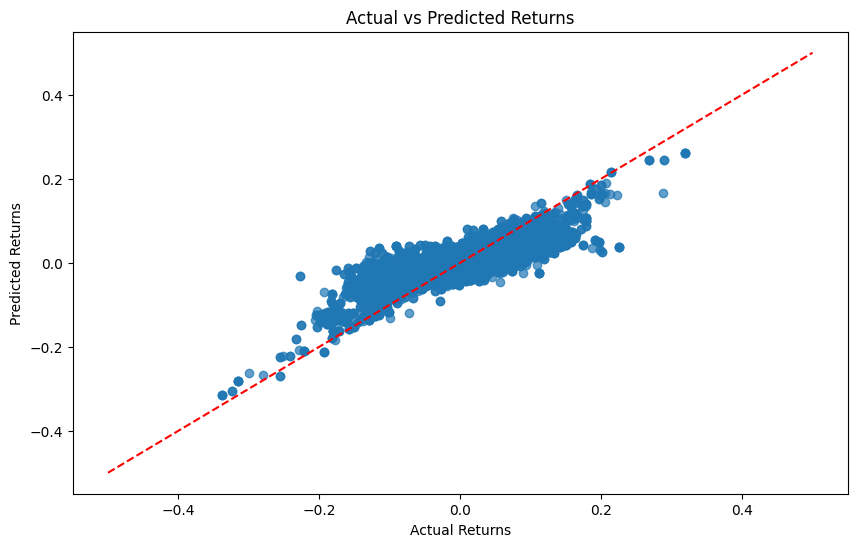

                           Adj Close      Close       High        Low  \
Date                                                                    
2010-02-03 00:00:00+00:00   6.002140   7.115357   7.150000   6.943571   
2010-02-04 00:00:00+00:00   5.785832   6.858929   7.084643   6.841786   
2010-02-05 00:00:00+00:00   5.888561   6.980714   7.000000   6.816071   
2010-02-08 00:00:00+00:00   5.848191   6.932857   7.067143   6.928571   
2010-02-09 00:00:00+00:00   5.910555   7.006786   7.053571   6.955357   
...                              ...        ...        ...        ...   
2022-12-23 00:00:00+00:00  25.158005  26.090000  26.190001  25.680000   
2022-12-27 00:00:00+00:00  25.013363  25.940001  26.100000  25.650000   
2022-12-28 00:00:00+00:00  24.627657  25.540001  26.120001  25.500000   
2022-12-29 00:00:00+00:00  25.273720  26.209999  26.290001  25.750000   
2022-12-30 00:00:00+00:00  25.485861  26.430000  26.459999  25.799999   

                                Open     Volume Ti

In [11]:
# Main Execution
if __name__ == '__main__':
    # Set parameters
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'ADBE', 'INTC']
    start_date = '2010-01-01'
    end_date = '2023-01-01'

    # Step 1: Fetch data
    data = fetch_data(tickers, start_date, end_date)

    # Step 2: Add features
    data = add_features(data)

    # Step 3: Prepare datasets
    X_train, X_test, y_train, y_test, tickers_train, tickers_test, scaler = prepare_datasets(data)

    # Step 4: Train model
    model = train_model(X_train, y_train)

    # Step 5: Backtest and evaluate
    results, portfolio_actual = backtest_model(model, X_test, y_test, tickers_test, scaler, data)

    # Visualize results
    visualize_results(results)
    print(data)